In [1]:
import os
import glob
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import lsst.sims.photUtils as photUtils

In [3]:
# Read in the LSST throughput curves
fdir = os.getenv('LSST_THROUGHPUTS_DEFAULT')
print('Reading throughputs from %s' % fdir)
lsst = {}
for f in ['g', 'r', 'i', 'z', 'y']:
    lsst[f] = photUtils.Bandpass()
    lsst[f].readThroughput(os.path.join(fdir, 'total_' + f + '.dat'), wavelen_min=450)

Reading throughputs from /Users/lynnej/lsstRepos/throughputs/baseline/


In [4]:
# Add some V band 
V = photUtils.Bandpass()
V.readThroughput('/Users/lynnej/seds/asteroids/harris_V.dat', wavelen_min=450)
# Add some JHK curves
fdir = os.getenv('THROUGHPUTS_DIR') + '/2MASS'
twomass = {}
for f in ('J', 'H', 'Ks'):
    twomass[f] = photUtils.Bandpass(wavelen_min = 1000, wavelen_max=2400)
    twomass[f].readThroughput(os.path.join(fdir, '2MASS_' + f + '.dat'))

Text(0.5,1,'Throughput curves')

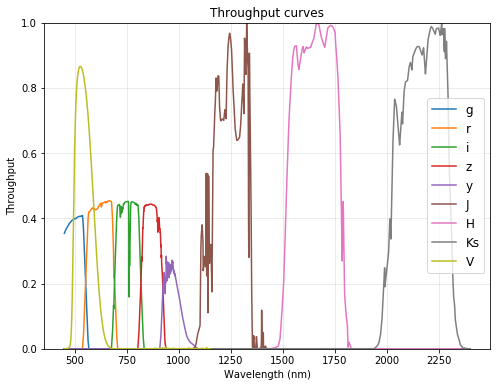

In [5]:
# Show curves
plt.figure(figsize=(8, 6))
for f in lsst:
    plt.plot(lsst[f].wavelen, lsst[f].sb, label=f)
for f in twomass:
    plt.plot(twomass[f].wavelen, twomass[f].sb, label=f)
plt.plot(V.wavelen, V.sb, label='V')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Throughput')
plt.legend(fancybox=True, fontsize='large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.title('Throughput curves')
# I suspect the 2mass curves do not include the atmosphere and possibly not QE from chip.
# Probably similar for the V band curve.
# the LSST curves do.

In [6]:
# Read in asteroid reflectance curves
astfiles = glob.glob('*.txt')
ast_ref = {}
for a in astfiles:
    name = os.path.split(a)[-1].rstrip('.txt')
    ast_ref[name] = photUtils.Sed()
    ast_ref[name].readSED_flambda(a)
    ast_ref[name].wavelen = ast_ref[name].wavelen*1000.0  # convert to nanometers from microns

Text(0.5,1,'Asteroid reflectance spectra')

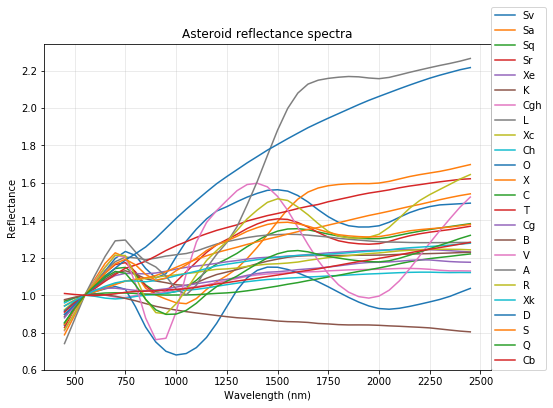

In [7]:
plt.figure(figsize=(8, 6))
for a in ast_ref:
    plt.plot(ast_ref[a].wavelen, ast_ref[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
#plt.xlim(400, 1200)
plt.title('Asteroid reflectance spectra')

Text(0.5,1,'Asteroid reflectance spectra')

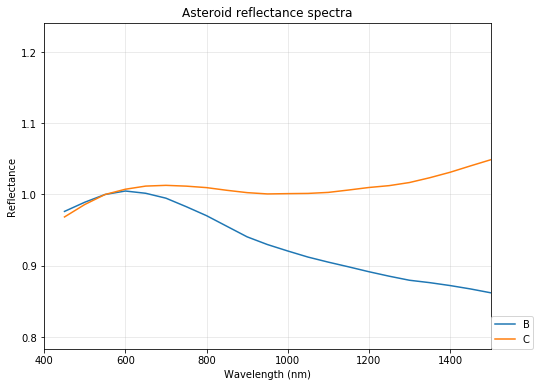

In [8]:
plt.figure(figsize=(8, 6))
for a in ['B', 'C']:
    plt.plot(ast_ref[a].wavelen, ast_ref[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
plt.xlim(400, 1500)
plt.title('Asteroid reflectance spectra')

Text(0,0.5,'Solar flux')

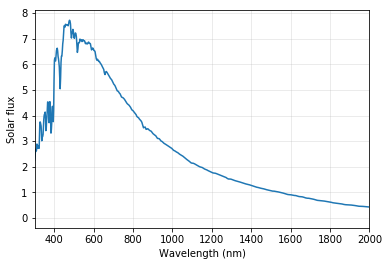

In [9]:
# Add solar spectra
sun = photUtils.Sed()
sun.readSED_flambda('kurucz_sun')
# Just rescale to avoid math overflow
sun.flambda = sun.flambda / 1000000.
plt.plot(sun.wavelen, sun.flambda)
plt.xlim(300, 2000)
plt.grid(True, alpha=0.3)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Solar flux')

In [10]:
asts = {}
for a in ast_ref:
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        asts[a] = ast_ref[a].multiplySED(sun)

Text(0.5,1,'Asteroid observed spectra')

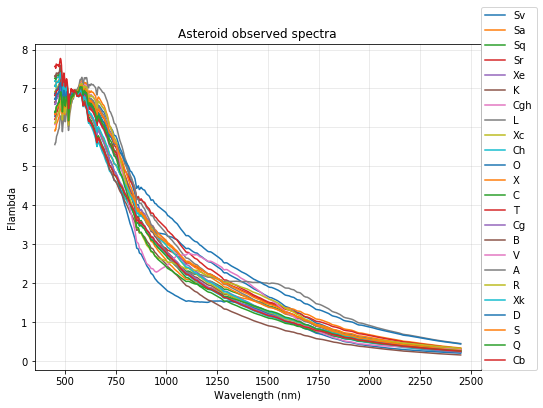

In [11]:
plt.figure(figsize=(8, 6))
for a in asts:
    plt.plot(asts[a].wavelen, asts[a].flambda, label=a)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flambda')
plt.grid(True, alpha=0.3)
plt.legend(loc=(1, 0.0), fancybox=True)
plt.title('Asteroid observed spectra')

In [62]:
# Calculate colors
astmags  = {}
for a in asts:
    astmags[a] = {}
    astmags[a]['V'] = asts[a].calcMag(V)
for a in asts:
    for f in twomass:
        astmags[a][f] = asts[a].calcMag(twomass[f])
    for f in lsst:
        astmags[a][f] = asts[a].calcMag(lsst[f])

In [63]:
print('Name \t  V-g  \t  V-r  \t  V-i \t  V-z  \t V-y \t V-J \t  V-H  \t  V-K   AB MAGS')
for a in asts:
    writestring = '%s' % a
    for f in lsst:
        vX = astmags[a]['V'] - astmags[a][f]
        writestring += ' \t%.3f' % (vX)
    for f in twomass:
        vX = astmags[a]['V'] - astmags[a][f]
        writestring += ' \t%.3f' % (vX)
    print(writestring)

Name 	  V-g  	  V-r  	  V-i 	  V-z  	 V-y 	 V-J 	  V-H  	  V-K   AB MAGS
Sv 	-0.209 	0.261 	0.486 	0.420 	0.455 	0.661 	0.539 	0.066
Sa 	-0.242 	0.296 	0.462 	0.328 	0.275 	0.358 	0.571 	0.214
Sq 	-0.206 	0.250 	0.416 	0.341 	0.320 	0.439 	0.429 	-0.010
Sr 	-0.215 	0.258 	0.435 	0.336 	0.350 	0.527 	0.443 	-0.024
Xe 	-0.190 	0.233 	0.399 	0.414 	0.439 	0.431 	0.322 	-0.084
K 	-0.191 	0.234 	0.403 	0.380 	0.367 	0.374 	0.312 	-0.108
Cgh 	-0.168 	0.177 	0.277 	0.305 	0.331 	0.336 	0.239 	-0.175
L 	-0.213 	0.265 	0.472 	0.484 	0.508 	0.520 	0.407 	-0.054
Xc 	-0.169 	0.201 	0.357 	0.386 	0.409 	0.394 	0.290 	-0.091
Ch 	-0.148 	0.161 	0.267 	0.295 	0.318 	0.311 	0.208 	-0.197
O 	-0.171 	0.198 	0.284 	0.059 	-0.088 	0.161 	0.208 	-0.382
X 	-0.161 	0.196 	0.355 	0.392 	0.436 	0.482 	0.430 	0.097
C 	-0.149 	0.177 	0.290 	0.295 	0.300 	0.264 	0.184 	-0.148
T 	-0.179 	0.224 	0.421 	0.481 	0.539 	0.582 	0.525 	0.173
Cg 	-0.187 	0.206 	0.319 	0.325 	0.347 	0.346 	0.254 	-0.134
B 	-0.146 	0.169 	0.

Text(0,0.5,'g-H AB')

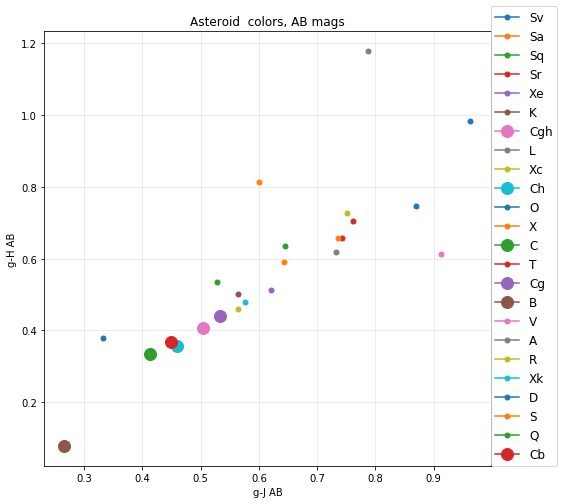

In [97]:
color1 = ['g', 'J']
color2 = ['g', 'H']
plt.figure(figsize=(8, 8))
plt.title('Asteroid  colors, AB mags')
specialasts = ['B', 'C', 'Cg', 'Cgh', 'Ch', 'Cb']
for a in asts:
    if a in specialasts:
        markersize = 12
    else:
        markersize = 5
    plt.plot(astmags[a][color1[0]] - astmags[a][color1[1]],
             astmags[a][color2[0]] - astmags[a][color2[1]],
             marker='o', markersize=markersize, label=a)
plt.legend(loc=(1, 0.), fancybox=True, fontsize='large')
plt.grid(True, alpha=0.3)
plt.xlabel('%s-%s AB' % (color1[0], color1[1]))
plt.ylabel('%s-%s AB' % (color2[0], color2[1]))

(300, 2500)

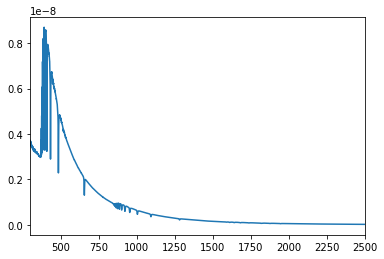

In [54]:
# Convert to vega mags
# read vega spectrum
import astropy.io.fits as fitsio
hdu1 = fitsio.open('alpha_lyr_stis_008.fits')
table = hdu1[1]
wavelen = table.data['WAVELENGTH']  # read wavelength, in angstroms
wavelen = wavelen / 10.0
flam = table.data['FLUX']
plt.plot(wavelen, flam)
plt.xlim(300, 2500)

In [68]:
vega = photUtils.Sed(wavelen=wavelen, flambda=flam)
# let's just scale so vega = 0 in V band
fluxnorm = vega.calcFluxNorm(0, V)
vega.multiplyFluxNorm(fluxnorm)

In [69]:
vegamags = {}
vegamags['V'] = vega.calcMag(V)
for f in lsst:
    vegamags[f]  = vega.calcMag(lsst[f])
for f in twomass:
    vegamags[f] = vega.calcMag(twomass[f])
print(vegamags)

{'V': 0.0, 'g': -0.071437068172651053, 'r': 0.14237420968411385, 'i': 0.36098160535013335, 'z': 0.50487973115265916, 'y': 0.54101744191690138, 'J': 0.89143139480878197, 'H': 1.364956518594064, 'Ks': 1.8350516488604587}


In [71]:
print('Name \t  V-g  \t  V-r  \t  V-i \t  V-z  \t V-y \t V-J \t  V-H  \t  V-K   Vega MAGS')
for a in asts:
    writestring = '%s' % a
    for f in lsst:
        vX = astmags[a]['V'] - astmags[a][f] + vegamags[f]
        writestring += ' \t%.3f' % (vX)
    for f in twomass:
        vX = astmags[a]['V'] - astmags[a][f] + vegamags[f]
        writestring += ' \t%.3f' % (vX)
    print(writestring)

Name 	  V-g  	  V-r  	  V-i 	  V-z  	 V-y 	 V-J 	  V-H  	  V-K   Vega MAGS
Sv 	-0.280 	0.404 	0.847 	0.925 	0.996 	1.553 	1.904 	1.901
Sa 	-0.313 	0.438 	0.823 	0.832 	0.816 	1.249 	1.936 	2.049
Sq 	-0.278 	0.392 	0.777 	0.846 	0.861 	1.330 	1.794 	1.825
Sr 	-0.286 	0.401 	0.796 	0.841 	0.891 	1.419 	1.808 	1.811
Xe 	-0.261 	0.375 	0.760 	0.919 	0.980 	1.323 	1.687 	1.751
K 	-0.262 	0.376 	0.764 	0.885 	0.908 	1.265 	1.677 	1.727
Cgh 	-0.239 	0.320 	0.638 	0.810 	0.872 	1.228 	1.604 	1.660
L 	-0.284 	0.407 	0.833 	0.989 	1.049 	1.412 	1.772 	1.781
Xc 	-0.241 	0.344 	0.718 	0.891 	0.950 	1.286 	1.655 	1.744
Ch 	-0.219 	0.303 	0.628 	0.800 	0.859 	1.203 	1.573 	1.638
O 	-0.243 	0.341 	0.645 	0.564 	0.453 	1.053 	1.573 	1.453
X 	-0.233 	0.339 	0.716 	0.897 	0.977 	1.374 	1.795 	1.932
C 	-0.221 	0.319 	0.651 	0.800 	0.841 	1.155 	1.549 	1.688
T 	-0.250 	0.366 	0.782 	0.986 	1.080 	1.473 	1.890 	2.008
Cg 	-0.258 	0.348 	0.680 	0.830 	0.888 	1.237 	1.619 	1.701
B 	-0.217 	0.312 	0.619 	0.739

Text(0,0.5,'g-H vega')

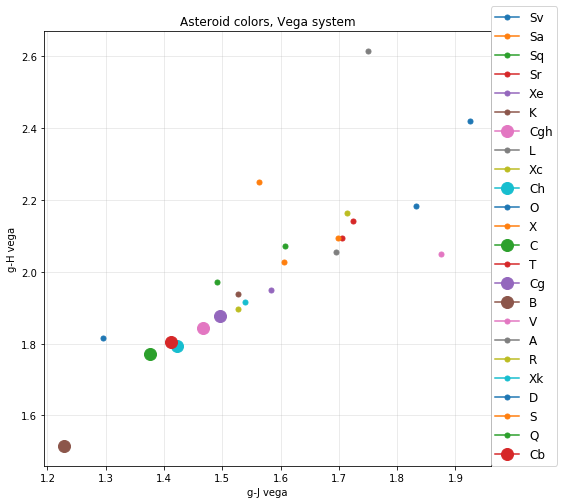

In [99]:
color1 = ['g', 'J']
color2 = ['g', 'H']
plt.figure(figsize=(8, 8))
plt.title('Asteroid colors, Vega system')
specialasts = ['B', 'C', 'Cg', 'Cgh', 'Ch', 'Cb']
for a in asts:
    if a in specialasts:
        markersize = 12
    else:
        markersize = 5
    plt.plot(astmags[a][color1[0]] - astmags[a][color1[1]] - (vegamags[color1[0]] - vegamags[color1[1]]),
             astmags[a][color2[0]] - astmags[a][color2[1]] - (vegamags[color2[0]] - vegamags[color2[1]]), 
             marker='o', markersize=markersize, label=a)
plt.legend(loc=(1, 0.), fancybox=True, fontsize='large')
plt.grid(True, alpha=0.3)
plt.xlabel('%s-%s vega' % (color1[0], color1[1]))
plt.ylabel('%s-%s vega' % (color2[0], color2[1]))